# Enem

### On this notebook, we want to export data for visualization with a web interface to have on overview of the education on the country and also answer the question:

### Is income an important factor in student performace on the enem test? 


In [1]:
import pandas as pd
print(pd.__version__)
import json
print(json.__version__)
import collections
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib.ticker as mtick

0.25.3
2.0.9


In [2]:
def show_heads(df):
    if 1: #change this to 1 to see heads on dataframes
        return df.head()

In [3]:
#you can donwload this data in 
#check the DICIONARIO folder to find information about the variables and codes on the data
df = pd.read_csv('./data/microdados_enem2018/DADOS/MICRODADOS_ENEM_2018.csv', 
                 delimiter=';',
                 encoding='ISO-8859-1', 
                 usecols=[
                         'NU_INSCRICAO', #student unique id
                         'TP_ST_CONCLUSAO', #high school situation (already over, finishing, ongoing, not on high school)
                         'CO_ESCOLA', #School code
                         'NO_MUNICIPIO_ESC',#School city name
                         'SG_UF_ESC', #School State code
                         'TP_DEPENDENCIA_ADM_ESC', #school dependency(federal gov., state gov., city gov., private)
                         'NU_NOTA_CN', #grade natural ciencies
                         'NU_NOTA_CH', #grades human ciencies
                         'NU_NOTA_LC', #grades languages and codes
                         'NU_NOTA_MT', #grades math
                         'NU_NOTA_REDACAO', #grades essay
                         'Q001', #how far did the mother go with her studies
                         'Q002',#how far did the father go with his studies
                         'Q005',#number of people living in the house
                         'Q006', #family income
                         ])

show_heads(df)  

,NU_INSCRICAO,TP_ST_CONCLUSAO,CO_ESCOLA,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q005,Q006
0,180008202043,2,52033333.0,Goiânia,GO,2.0,NaN,NaN,NaN,NaN,NaN,A,A,1,A
1,180007197856,1,NaN,NaN,NaN,NaN,521.0,568.7,513.1,480.3,280.0,B,B,4,B
2,180008517434,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,E,4,C
3,180007661228,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,4,B
4,180008787987,2,29112699.0,Jeremoabo,BA,2.0,NaN,419.9,345.8,NaN,360.0,C,E,3,B


I would like to know how nan values behave in columns

In [4]:
print(df.isna().sum())

NU_INSCRICAO                    0
TP_ST_CONCLUSAO                 0
CO_ESCOLA                 4064926
NO_MUNICIPIO_ESC          4064926
SG_UF_ESC                 4064926
TP_DEPENDENCIA_ADM_ESC    4064926
NU_NOTA_CN                1608648
NU_NOTA_CH                1365483
NU_NOTA_LC                1365483
NU_NOTA_MT                1608648
NU_NOTA_REDACAO           1365483
Q001                            0
Q002                            0
Q005                            0
Q006                            0
dtype: int64


The above tells us that everyone answered social-economic questions. Those that have no school are presumably graduated before the reference year. Those that have nan values to grades missed the testes

We are interested on the students graduating from high school that took all the tests. So we can drop all nan values and select by students graduating 

In [5]:
total = len(df)
print('Total:', total)
#drop non assigned grades and non assigned schools
df = df.dropna()
#drop students that are not finishing this year
df = df[df['TP_ST_CONCLUSAO']==2]
#drop grades 0 in CN, CH, LC, MT, because it should not be possible to receive these grades
df = df[df['NU_NOTA_CN']>0]
df = df[df['NU_NOTA_CH']>0]
df = df[df['NU_NOTA_LC']>0]
df = df[df['NU_NOTA_MT']>0]
print('High school students that took all the tests:', len(df))

Total: 5513747
High school students that took all the tests: 1129103


The first information we want is grades per school

In [6]:
school_perform = df[[
    'CO_ESCOLA', #School code
    'NU_NOTA_CN', #grade natural ciencies
    'NU_NOTA_CH', #grades human ciencies
    'NU_NOTA_LC', #grades languages and codes
    'NU_NOTA_MT', #grades math
    'NU_NOTA_REDACAO', #grades essay
]].groupby(by='CO_ESCOLA').agg('mean')
print('Total School:', len(school_perform))

show_heads(school_perform)

Total School: 30929


,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
CO_ESCOLA,,,,,
11000058.0,599.592701,654.083212,598.710949,658.561314,714.452555
11000171.0,505.911111,614.144444,562.977778,590.444444,560.000000
11000180.0,463.700000,518.600000,515.100000,464.185714,494.285714
11000198.0,555.482051,612.312821,585.317949,592.935897,627.179487
11000244.0,516.750000,592.539286,541.471429,594.932143,574.285714


In [7]:
school_props = df[[
     'CO_ESCOLA', #School code
     'NO_MUNICIPIO_ESC',#School city name
     'SG_UF_ESC', #School State code
     'TP_DEPENDENCIA_ADM_ESC', #school dependency(federal gov., state gov., city gov., private)              
]].groupby(by='CO_ESCOLA').nth(0)
show_heads(school_props)

,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC
CO_ESCOLA,,,
11000058.0,Porto Velho,RO,4.0
11000171.0,Porto Velho,RO,4.0
11000180.0,Porto Velho,RO,4.0
11000198.0,Porto Velho,RO,4.0
11000244.0,Porto Velho,RO,4.0


To create a map with the performance accross the country, we need to select:
- the best schools in each city on each category
    - Federal school.
    - State school.
    - Municipal school.
    - Private school
- the mean value for school performance in each city

In [8]:
schools = school_perform.join(school_props, on='CO_ESCOLA', how='inner')
show_heads(schools)

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC
CO_ESCOLA,,,,,,,,
11000058.0,599.592701,654.083212,598.710949,658.561314,714.452555,Porto Velho,RO,4.0
11000171.0,505.911111,614.144444,562.977778,590.444444,560.000000,Porto Velho,RO,4.0
11000180.0,463.700000,518.600000,515.100000,464.185714,494.285714,Porto Velho,RO,4.0
11000198.0,555.482051,612.312821,585.317949,592.935897,627.179487,Porto Velho,RO,4.0
11000244.0,516.750000,592.539286,541.471429,594.932143,574.285714,Porto Velho,RO,4.0


In [9]:
schools['NU_NOTA_SUM'] = (  schools['NU_NOTA_CN'] 
                          + schools['NU_NOTA_CH'] 
                          + schools['NU_NOTA_LC'] 
                          + schools['NU_NOTA_MT']
                          + schools['NU_NOTA_REDACAO'])/5
bycity = (schools
    .groupby(by = ['SG_UF_ESC', 'NO_MUNICIPIO_ESC', 'TP_DEPENDENCIA_ADM_ESC'])
    .agg(
        NU_NOTA_CN = ('NU_NOTA_CN', 'mean'),
        NU_NOTA_CH = ('NU_NOTA_CH', 'mean'),
        NU_NOTA_LC = ('NU_NOTA_LC', 'mean'),
        NU_NOTA_MT = ('NU_NOTA_MT', 'mean'),
        NU_NOTA_REDACAO = ('NU_NOTA_REDACAO','mean'),
        NU_NOTA_SUM = ('NU_NOTA_SUM', 'max'),
        NU_NOTA_AVG = ('NU_NOTA_SUM', 'mean')
    ))
show_heads(bycity)

NU_NOTA_CN  NU_NOTA_CH  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC                           
AC        Acrelândia       2.0                     455.767614  542.231818   
                           3.0                     480.300000  435.600000   
          Assis Brasil     2.0                     473.858929  531.571429   
          Brasiléia        2.0                     460.677820  537.714887   
                           3.0                     405.050000  577.750000   

                                                   NU_NOTA_LC  NU_NOTA_MT  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC                           
AC        Acrelândia       2.0                     493.131250  493.628409   
                           3.0                     405.300000  441.100000   
          Assis Brasil     2.0                     494.978571  471.541071   
          Brasiléia        2.0                     496.735265  488.574184   
                           3.0                     527.950000  509.450000   

                                                   NU_NOTA_REDACAO  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC                    
AC        Acrelândia       2.0                          460.113636   
                           3.0                          540.000000   
          Assis Brasil     2.0                          372.500000   
          Brasiléia        2.0                          469.796557   
                           3.0                          460.000000   

                                                   NU_NOTA_SUM  NU_NOTA_AVG  
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC                            
AC        Acrelândia       2.0                      504.040000   488.974545  
                           3.0                      460.460000   460.460000  
          Assis Brasil     2.0                      485.740000   468.890000  
          Brasiléia        2.0                      507.676667   490.699742  
                           3.0                      499.660000   496.040000

In [10]:
bystate = (schools
    .drop(columns='NO_MUNICIPIO_ESC')
    .groupby(by = ['SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC'])
    .agg(
        NU_NOTA_CN = ('NU_NOTA_CN', 'mean'),
        NU_NOTA_CH = ('NU_NOTA_CH', 'mean'),
        NU_NOTA_LC = ('NU_NOTA_LC', 'mean'),
        NU_NOTA_MT = ('NU_NOTA_MT', 'mean'),
        NU_NOTA_REDACAO = ('NU_NOTA_REDACAO','mean'),
        NU_NOTA_SUM = ('NU_NOTA_SUM', 'max'),
        NU_NOTA_AVG = ('NU_NOTA_SUM', 'mean')
    ))
show_heads(bystate)

NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC                                       
AC        1.0                     497.993575  566.875786  531.822524   
          2.0                     446.970091  513.365165  469.917626   
          3.0                     435.559091  514.704545  453.509091   
          4.0                     530.401510  597.079097  563.321943   
AL        1.0                     510.783673  585.118488  549.277717   

                                  NU_NOTA_MT  NU_NOTA_REDACAO  NU_NOTA_SUM  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC                                             
AC        1.0                     523.539917       567.867480   571.032000   
          2.0                     477.605250       402.836612   556.060000   
          3.0                     459.381818       455.454545   499.660000   
          4.0                     562.238050       624.622151   642.716571   
AL        1.0                     563.940709       612.099368   628.995507   

                                  NU_NOTA_AVG  
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC               
AC        1.0                      537.619856  
          2.0                      462.138949  
          3.0                      463.721818  
          4.0                      575.532550  
AL        1.0                      564.243991

In [11]:
def grades_as_int(df):
    return df.astype({
        'NU_NOTA_CN': np.int, 
        'NU_NOTA_CH': np.int, 
        'NU_NOTA_LC': np.int, 
        'NU_NOTA_MT': np.int, 
        'NU_NOTA_REDACAO': np.int, 
        'NU_NOTA_SUM': np.int,
        'NU_NOTA_AVG': np.int
    })
def parse_as_json(df):
    nested_dict = lambda: collections.defaultdict(nested_dict)
    j = nested_dict()
    for row in df.itertuples():
        j_l = j
        for i in row.Index[:-1]:
            j_l = j_l[i]
        j_l[row.Index[-1]] = [
            row.NU_NOTA_CN, 
            row.NU_NOTA_CH, 
            row.NU_NOTA_LC, 
            row.NU_NOTA_MT, 
            row.NU_NOTA_REDACAO, 
            row.NU_NOTA_SUM,
            row.NU_NOTA_AVG
        ]
    return j

bycity = grades_as_int(bycity)
bystate = grades_as_int(bystate)

min_val = bycity.min()
max_val = bycity.max()

bycityexport = parse_as_json(bycity)
bystateexport = parse_as_json(bystate)
exportedJson = {
    'dictionary':['CN', 'CH', 'LC', 'MT', 'REDACAO', 'SUM', 'AVG'],
    'limits': {
        'general':[
            int(min_val.drop('NU_NOTA_REDACAO').min()),
            int(max_val.drop('NU_NOTA_REDACAO').min())
        ],
        'redacao':[
            int(min_val['NU_NOTA_REDACAO']),
            int(max_val['NU_NOTA_REDACAO'])
        ]
    },
    'city': bycityexport,
    'state': bystateexport
}
with open('./exports/byschool.json', 'w') as f:
    json.dump(exportedJson, f)

The first question we would like to answer with this data is whether per person family income is an important factor in student performace on the enem test or not. 

We consider that the school type a student has attendent has a major influence on their grades. In Brazil, private schools are considered to be a better choice. Federal schools are also considered to be good. The ones managed by state gov. and city gov. are usually considered to provide poor education. For that reason, we split students based on the school type they attended. Furthermore, later on this investigation, we normalize student grades by their school average grade, as to see how the student perform compared with their peers

In [12]:
incomeTh =  [
    0, #padding
    0,
    954,
    1431,
    1908,
    2385,
    2862,
    3816,
    4770,
    5724,
    6678,
    7632,
    8556,
    9540,
    11448,
    14310,
    19080,
    19080*2
]
incomeClasses = {}
for idx, c in enumerate(list('ABCDEFGHIJKLMNOPQ'), start=1):
    incomeClasses[c]=(incomeTh[idx-1] + incomeTh[idx])/2
    
df2 = df
df2 = df2.replace({'Q006':incomeClasses}) 
df2['INCOME_PER_PERSON'] = df2['Q006']/df2['Q005']
show_heads(df2)


,NU_INSCRICAO,TP_ST_CONCLUSAO,CO_ESCOLA,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q005,Q006,INCOME_PER_PERSON
8,180008257068,2,23077140.0,Fortaleza,CE,2.0,411.8,429.8,445.2,459.0,340.0,D,D,7,1192.5,170.357143
16,180007766857,2,23265795.0,Camocim,CE,2.0,478.5,513.3,564.7,514.9,580.0,C,C,5,477.0,95.400000
26,180008895630,2,25077759.0,Lagoa Seca,PB,2.0,479.4,539.0,553.8,517.3,620.0,H,E,7,477.0,68.142857
29,180008411104,2,22022040.0,Teresina,PI,2.0,429.8,586.7,450.3,473.3,300.0,B,A,5,477.0,95.400000
39,180007286708,2,35907224.0,Araçatuba,SP,2.0,390.0,524.1,492.5,462.0,500.0,D,E,3,1192.5,397.500000


we need to put INCOME_PER_PERSON back as a discrete variable. I will split in the original setup (17 bins). First let me take a look if is smart to split in equal width bins


<IPython.core.display.Javascript object>


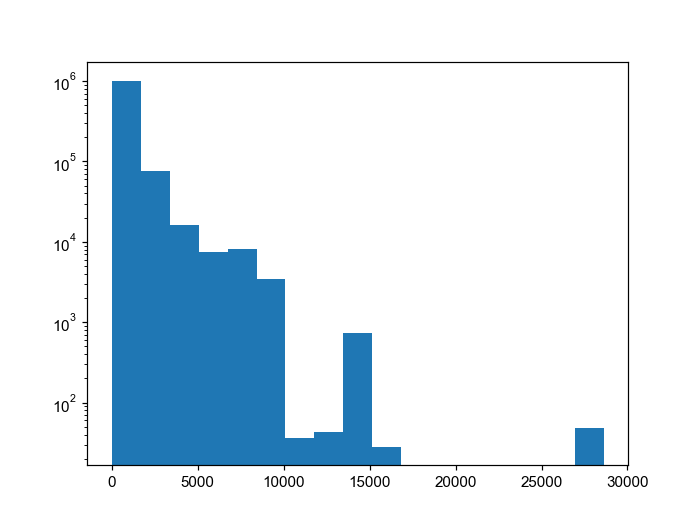

(array([1.015956e+06, 7.696000e+04, 1.613800e+04, 7.505000e+03,
        8.168000e+03, 3.486000e+03, 3.600000e+01, 4.300000e+01,
        7.340000e+02, 2.800000e+01, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        4.900000e+01]),
 array([    0.        ,  1683.52941176,  3367.05882353,  5050.58823529,
         6734.11764706,  8417.64705882, 10101.17647059, 11784.70588235,
        13468.23529412, 15151.76470588, 16835.29411765, 18518.82352941,
        20202.35294118, 21885.88235294, 23569.41176471, 25252.94117647,
        26936.47058824, 28620.        ]),
 <a list of 17 Patch objects>)

In [13]:
plt.figure()
plt.yscale('log')
plt.hist(df2['INCOME_PER_PERSON'], bins = 17)


spliting in equal bins is a bad idea. I will take the suggestion from the enem and limit the upper value by 19080 (a parent and a student). 

The values on the histogram bigger than (19080 + 2*19080)/4 = 14310 indicates that whether some students are doing really well on themselves (making more than 14310 BRL) or they have filled the form wrong. In any case, making the latter bin in income per person 19080/2 or more are going to filter those outliers

<IPython.core.display.Javascript object>


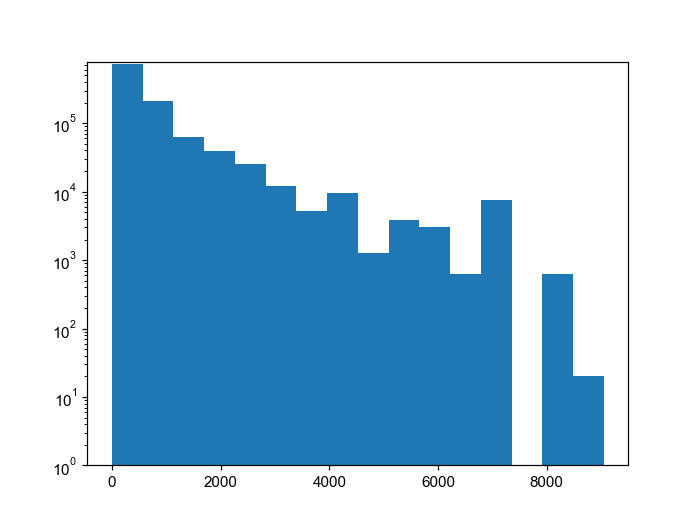

In [14]:
plt.figure()
plt.hist(df2.loc[df2['INCOME_PER_PERSON']<19080/2, 'INCOME_PER_PERSON'], bins=16)
plt.ylim(bottom=1)  # adjust the bottom leaving top unchanged
plt.yscale('log')


Using equal width bins did not work well. It is better to split the data in equal sized bins.

In [15]:
df2['INCOME_PER_PERSON_CATEGORY'], income_per_person_bins = pd.qcut(
    df2.loc[df2['INCOME_PER_PERSON']>0, 'INCOME_PER_PERSON'],
    q = 16,
    labels=list('BCDEFGHIJKLMNOPQ'),
    retbins=True
)
df2 = df2.astype({
    'INCOME_PER_PERSON_CATEGORY': str
})
df2.loc[df2['INCOME_PER_PERSON']==0, 'INCOME_PER_PERSON_CATEGORY'] = 'A'
show_heads(df2)

,NU_INSCRICAO,TP_ST_CONCLUSAO,CO_ESCOLA,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q005,Q006,INCOME_PER_PERSON,INCOME_PER_PERSON_CATEGORY
8,180008257068,2,23077140.0,Fortaleza,CE,2.0,411.8,429.8,445.2,459.0,340.0,D,D,7,1192.5,170.357143,E
16,180007766857,2,23265795.0,Camocim,CE,2.0,478.5,513.3,564.7,514.9,580.0,C,C,5,477.0,95.400000,B
26,180008895630,2,25077759.0,Lagoa Seca,PB,2.0,479.4,539.0,553.8,517.3,620.0,H,E,7,477.0,68.142857,B
29,180008411104,2,22022040.0,Teresina,PI,2.0,429.8,586.7,450.3,473.3,300.0,B,A,5,477.0,95.400000,B
39,180007286708,2,35907224.0,Araçatuba,SP,2.0,390.0,524.1,492.5,462.0,500.0,D,E,3,1192.5,397.500000,I


Now we can finally group the information

In [31]:
aux = df2[[
    'NO_MUNICIPIO_ESC',#School city name
    'SG_UF_ESC', #School State code
    'TP_DEPENDENCIA_ADM_ESC', #school dependency(federal gov., state gov., city gov., private)                  
    'NU_NOTA_CN', #grade natural ciencies
    'NU_NOTA_CH', #grades human ciencies
    'NU_NOTA_LC', #grades languages and codes
    'NU_NOTA_MT', #grades math
    'NU_NOTA_REDACAO', #grades essay
    'INCOME_PER_PERSON_CATEGORY'
]].groupby(by = [
    'SG_UF_ESC', 
    'NO_MUNICIPIO_ESC', 
    'TP_DEPENDENCIA_ADM_ESC', 
    'INCOME_PER_PERSON_CATEGORY'])
byincome_city_scholltype = aux.agg('mean')
byincome_city_scholltype_minmax=[
    byincome_city_scholltype.drop(columns='NU_NOTA_REDACAO').min(axis=1).min(),
    byincome_city_scholltype.drop(columns='NU_NOTA_REDACAO').max(axis=1).max()
]
byincome_city_scholltype['OCCURENCIES'] = aux.count()['NU_NOTA_CN']

show_heads(byincome_city_scholltype)

NU_NOTA_CN  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        Acrelândia       2.0                    A                           447.714286   
                                                  B                           491.018182   
                                                  C                           443.244444   
                                                  D                           451.580000   
                                                  E                           433.375000   

                                                                              NU_NOTA_CH  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        Acrelândia       2.0                    A                           526.028571   
                                                  B                           557.781818   
                                                  C                           536.455556   
                                                  D                           490.020000   
                                                  E                           595.200000   

                                                                              NU_NOTA_LC  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        Acrelândia       2.0                    A                           445.457143   
                                                  B                           479.063636   
                                                  C                           476.233333   
                                                  D                           475.120000   
                                                  E                           545.625000   

                                                                              NU_NOTA_MT  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        Acrelândia       2.0                    A                           466.357143   
                                                  B                           535.245455   
                                                  C                           489.611111   
                                                  D                           466.200000   
                                                  E                           577.725000   

                                                                              NU_NOTA_REDACAO  \
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY                    
AC        Acrelândia       2.0                    A                                385.714286   
                                                  B                                487.272727   
                                                  C                                435.555556   
                                                  D                                460.000000   
                                                  E                                565.000000   

                                                                              OCCURENCIES  
SG_UF_ESC NO_MUNICIPIO_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        Acrelândia       2.0                    A                                     7  
                                                  B                                    11  
                                                  C                                     9  
                                                  D                                     5  
                                                  E                                     4

In [32]:
aux = df2[[
    'SG_UF_ESC', #School State code
    'TP_DEPENDENCIA_ADM_ESC', #school dependency(federal gov., state gov., city gov., private)                  
    'NU_NOTA_CN', #grade natural ciencies
    'NU_NOTA_CH', #grades human ciencies
    'NU_NOTA_LC', #grades languages and codes
    'NU_NOTA_MT', #grades math
    'NU_NOTA_REDACAO', #grades essay
    'INCOME_PER_PERSON_CATEGORY'
]].groupby(by = [
    'SG_UF_ESC', 
    'TP_DEPENDENCIA_ADM_ESC', 
    'INCOME_PER_PERSON_CATEGORY'])
byincome_state_scholltype = aux.agg('mean')
byincome_state_scholltype_minmax=[
    byincome_state_scholltype.drop(columns='NU_NOTA_REDACAO').min(axis=1).min(),
    byincome_state_scholltype.drop(columns='NU_NOTA_REDACAO').max(axis=1).max()
]
byincome_state_scholltype['OCCURENCIES'] = aux.count()['NU_NOTA_CN']

show_heads(byincome_state_scholltype)

NU_NOTA_CN  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        1.0                    A                           479.740000   
                                 B                           454.403846   
                                 C                           492.720000   
                                 D                           487.747059   
                                 E                           501.600000   

                                                             NU_NOTA_CH  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        1.0                    A                           521.760000   
                                 B                           535.130769   
                                 C                           548.093333   
                                 D                           532.541176   
                                 E                           564.542857   

                                                             NU_NOTA_LC  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        1.0                    A                           467.660000   
                                 B                           491.234615   
                                 C                           505.580000   
                                 D                           516.817647   
                                 E                           521.385714   

                                                             NU_NOTA_MT  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        1.0                    A                           471.560000   
                                 B                           493.315385   
                                 C                           493.646667   
                                 D                           490.947059   
                                 E                           477.942857   

                                                             NU_NOTA_REDACAO  \
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY                    
AC        1.0                    A                                420.000000   
                                 B                                513.076923   
                                 C                                516.000000   
                                 D                                516.470588   
                                 E                                520.000000   

                                                             OCCURENCIES  
SG_UF_ESC TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
AC        1.0                    A                                     5  
                                 B                                    26  
                                 C                                    15  
                                 D                                    17  
                                 E                                     7

In [33]:
aux = df2[[
    'TP_DEPENDENCIA_ADM_ESC', #school dependency(federal gov., state gov., city gov., private)                  
    'NU_NOTA_CN', #grade natural ciencies
    'NU_NOTA_CH', #grades human ciencies
    'NU_NOTA_LC', #grades languages and codes
    'NU_NOTA_MT', #grades math
    'NU_NOTA_REDACAO', #grades essay
    'INCOME_PER_PERSON_CATEGORY'
]].groupby(by = [
    'TP_DEPENDENCIA_ADM_ESC', 
    'INCOME_PER_PERSON_CATEGORY'])
byincome_scholltype = aux.agg('mean')
byincome_scholltype_minmax=[
    byincome_scholltype.drop(columns='NU_NOTA_REDACAO').min(axis=1).min(),
    byincome_scholltype.drop(columns='NU_NOTA_REDACAO').max(axis=1).max()
]
byincome_scholltype['OCCURENCIES'] = aux.count()['NU_NOTA_CN']

show_heads(byincome_scholltype)

NU_NOTA_CN  NU_NOTA_CH  \
TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY                           
1.0                    A                           510.018973  579.111127   
                       B                           500.588392  571.952029   
                       C                           508.753416  580.711907   
                       D                           513.328873  588.775736   
                       E                           507.415625  583.335054   

                                                   NU_NOTA_LC  NU_NOTA_MT  \
TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY                           
1.0                    A                           538.914836  544.946648   
                       B                           531.760863  535.578582   
                       C                           541.064753  546.874004   
                       D                           548.164908  557.981788   
                       E                           543.506793  548.546332   

                                                   NU_NOTA_REDACAO  \
TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY                    
1.0                    A                                581.483595   
                       B                                568.556754   
                       C                                588.500949   
                       D                                600.732926   
                       E                                584.673913   

                                                   OCCURENCIES  
TP_DEPENDENCIA_ADM_ESC INCOME_PER_PERSON_CATEGORY               
1.0                    A                                   701  
                       B                                  1947  
                       C                                  2108  
                       D                                  1801  
                       E                                   736

<IPython.core.display.Javascript object>


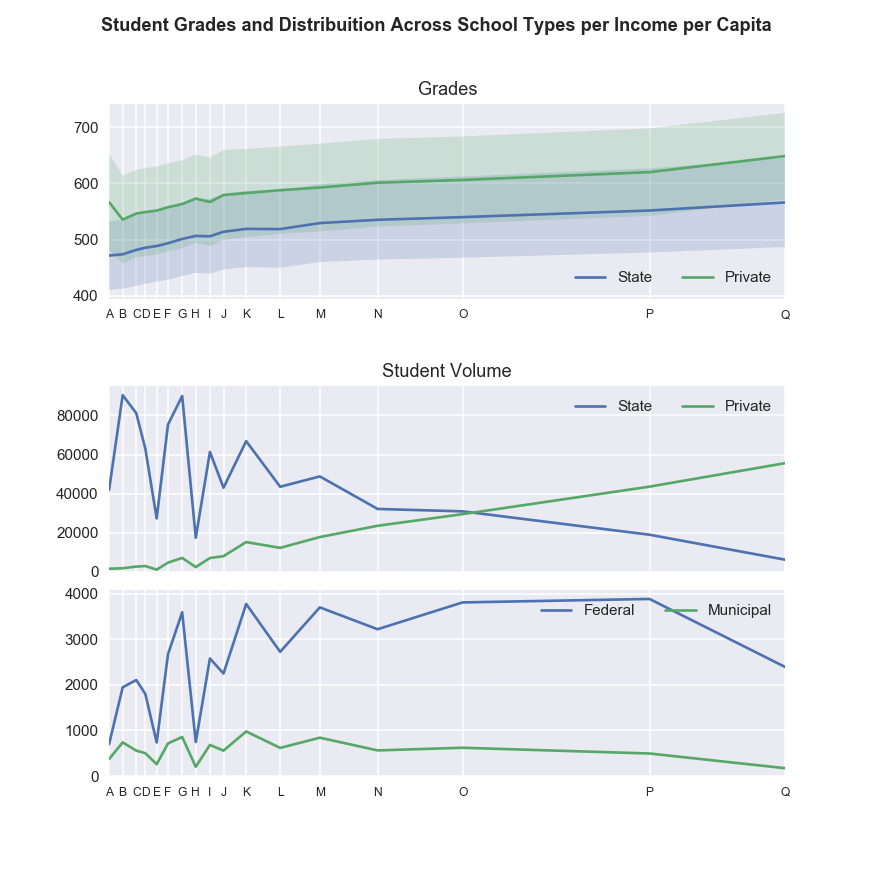

count                                                    \
          11.9250   59.6250   107.3250  139.1250  178.8750  218.6250    
Federal         701      1947      2108      1801       736      2673   
Municipal       371       738       557       500       259       716   
Private        1628      1904      2739      3014      1189      4757   
State         41973     90393     81156     63008     27349     75358   

                                                   ...        std             \
          268.3125  316.0125  365.7000  413.4000   ...  316.0125   365.7000    
Federal        3594       746      2580      2250  ...  72.990174  69.911918   
Municipal       857       202       682       557  ...  68.728686  71.349030   
Private        7160      2478      7111      8072  ...  78.262644  78.789832   
State         89969     17481     61344     43076  ...  65.544722  66.488455   

                                                                             \
           413.4000   492.9000   612.1500   751.2750   954.0000   1252.1250   
Federal    68.975970  70.132710  71.427687  69.291650  69.786829  68.368710   
Municipal  72.948030  70.349100  72.772738  71.657940  74.243236  69.826730   
Private    80.107068  78.191643  77.370569  77.906189  77.852330  77.277790   
State      66.939808  67.913045  68.653072  69.235260  70.556976  72.174296   

                                 
           1908.0000  2385.0000  
Federal    68.242238  68.545468  
Municipal  68.699091  72.678025  
Private    77.714147  76.725139  
State      74.662126  79.074329  

[4 rows x 51 columns]

In [34]:
binst = np.insert(income_per_person_bins, 0, 0)
bins = (binst[1:] + binst[:-1])/2
bins[-1] = binst[-2]

replace = {}
for i, c in enumerate(list('ABCDEFGHIJKLMNOPQ')):
    replace[c] = bins[i]

grades0 = pd.DataFrame(df2[[
    'TP_DEPENDENCIA_ADM_ESC', #school dependency(federal gov., state gov., city gov., private)                  
    'INCOME_PER_PERSON_CATEGORY'
]])

grades0['NU_SUM'] = df2[[
    'NU_NOTA_CN', #grade natural ciencies
    'NU_NOTA_CH', #grades human ciencies
    'NU_NOTA_LC', #grades languages and codes
    'NU_NOTA_MT', #grades math
    'NU_NOTA_REDACAO', #grades essay
]].mean(axis=1)

grades = (
    grades0.groupby(by = [
        'TP_DEPENDENCIA_ADM_ESC', 
        'INCOME_PER_PERSON_CATEGORY'
    ])
    .agg(['mean', 'std', 'count'])
    .rename(index=replace, level=1)
    .rename(index={
        1.0: 'Federal',
        2.0: 'State',
        3.0: 'Municipal',
        4.0: 'Private'
    }, level=0)
    .droplevel(level=0, axis=1)
)
 
grades = (grades
    .reset_index()
    .pivot_table(
        index='TP_DEPENDENCIA_ADM_ESC',
        columns='INCOME_PER_PERSON_CATEGORY'
    )
)

grades.index.names=[None]
grades.columns.names=[None, None]

plt.style.use('seaborn')
fig = plt.figure(figsize = (8,8))
outer = fig.add_gridspec(2, 1, wspace=0.2, hspace=0.3, height_ratios=[1,2])
inner = outer[1].subgridspec(2, 1, wspace=0.1, hspace=0.1)

ax = fig.add_subplot(outer[0])
grades.loc[['State', 'Private'],'mean'].T.plot(ax=ax)
ax.fill_between(
    grades.loc['State','mean'].T.index.values,
    (grades.loc['State','mean'].T - grades.loc['State','std'].T).values,
    (grades.loc['State','mean'].T + grades.loc['State','std'].T).values,
    alpha=0.2
)
ax.fill_between(
    grades.loc['Private','mean'].T.index.values,
    (grades.loc['Private','mean'].T - grades.loc['Private','std'].T).values,
    (grades.loc['Private','mean'].T + grades.loc['Private','std'].T).values,
    alpha=0.2
)
ax.legend(ncol=4, loc='lower right')
ax.set_title('Grades')
plt.xticks(bins, labels='ABCDEFGHIJKLMNOPQ', fontsize=8)

ax = fig.add_subplot(inner[0])
grades.loc[['State', 'Private'], 'count'].T.plot(ax=ax)
ax.legend(ncol=2, loc='upper right')
ax.set_title('Student Volume')
ax.set_ylim(bottom=0)
_ = plt.xticks(bins, labels='')

ax = fig.add_subplot(inner[1])
grades.loc[['Federal', 'Municipal'], 'count'].T.plot(ax=ax)
ax.legend(ncol=2, loc='upper right')
ax.set_ylim(bottom=0)
_ = plt.xticks(bins, labels='ABCDEFGHIJKLMNOPQ', fontsize=8)

fig.suptitle('Student Grades and Distribuition Across School Types per Income per Capita', fontweight='bold')

show_heads(grades)

In [35]:
_, p = stats.f_oneway(*[grades0.loc[
    (grades0['TP_DEPENDENCIA_ADM_ESC'] == 2.0) & 
    (grades0['INCOME_PER_PERSON_CATEGORY'] == c), 
    'NU_SUM'
].values for c in 'ABCDEFGHIJKLMNOPQ'])
print('P values from ANOVA')
print('  State school:', p)
_, p = stats.f_oneway(*[grades0.loc[
    (grades0['TP_DEPENDENCIA_ADM_ESC'] == 4.0) & 
    (grades0['INCOME_PER_PERSON_CATEGORY'] == c), 
    'NU_SUM'
].values for c in 'ABCDEFGHIJKLMNOPQ'])
print('  Private school:', p)

P values from ANOVA
  State school: 0.0
  Private school: 0.0


Now i have to export this data

In [36]:
def grades_as_int(df):
    return df.astype({
        'NU_NOTA_CN': np.int, 
        'NU_NOTA_CH': np.int, 
        'NU_NOTA_LC': np.int, 
        'NU_NOTA_MT': np.int, 
        'NU_NOTA_REDACAO': np.int,
    })
def parse_as_json(df):
    nested_dict = lambda: collections.defaultdict(nested_dict)
    j = nested_dict()
    for row in df.itertuples():
        j_l = j
        for i in row.Index[:-1]:
            j_l = j_l[i]
        j_l[row.Index[-1]] = [
            row.NU_NOTA_CN, 
            row.NU_NOTA_CH, 
            row.NU_NOTA_LC, 
            row.NU_NOTA_MT, 
            row.NU_NOTA_REDACAO, 
        ]
    return j

exportedbyincome_city = parse_as_json(grades_as_int(byincome_city_scholltype))
exportedbyincome_state = parse_as_json(grades_as_int(byincome_state_scholltype))
exportedbyincome = parse_as_json(grades_as_int(byincome_scholltype))

exported = {
    'country': exportedbyincome,
    'state': exportedbyincome_state,
    'city': exportedbyincome_city,
    'income_bins': list(income_per_person_bins),
    'dictionary':['CN', 'CH', 'LC', 'MT', 'REDACAO'],
    'limits':{
        'city': byincome_city_scholltype_minmax,
        'state': byincome_state_scholltype_minmax,
        'country': byincome_scholltype_minmax
    }
}

with open('./exports/byincome.json', 'w') as f:
    json.dump(exported, f)

The next step is to normalize student grade by its colegues on his school.

On the chart, we will left out Federal and Municipal schools, since there are too few students attending those. 

In [22]:
df3 = df2.join(school_perform, on='CO_ESCOLA', rsuffix='_SCHOOL', how='inner')
show_heads(df3)

,NU_INSCRICAO,TP_ST_CONCLUSAO,CO_ESCOLA,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,...,Q002,Q005,Q006,INCOME_PER_PERSON,INCOME_PER_PERSON_CATEGORY,NU_NOTA_CN_SCHOOL,NU_NOTA_CH_SCHOOL,NU_NOTA_LC_SCHOOL,NU_NOTA_MT_SCHOOL,NU_NOTA_REDACAO_SCHOOL
8,180008257068,2,23077140.0,Fortaleza,CE,2.0,411.8,429.8,445.2,459.0,...,D,7,1192.5,170.357143,E,451.996875,527.85375,479.835,485.2025,409.875
451,180008309669,2,23077140.0,Fortaleza,CE,2.0,457.3,564.2,474.6,462.9,...,D,7,1192.5,170.357143,E,451.996875,527.85375,479.835,485.2025,409.875
1674,180008206262,2,23077140.0,Fortaleza,CE,2.0,410.5,474.8,515.6,490.7,...,D,7,1192.5,170.357143,E,451.996875,527.85375,479.835,485.2025,409.875
3609,180008412463,2,23077140.0,Fortaleza,CE,2.0,506.9,590.0,493.2,438.6,...,D,7,1192.5,170.357143,E,451.996875,527.85375,479.835,485.2025,409.875
4813,180008415656,2,23077140.0,Fortaleza,CE,2.0,446.1,566.0,343.7,468.2,...,D,7,1192.5,170.357143,E,451.996875,527.85375,479.835,485.2025,409.875


<IPython.core.display.Javascript object>


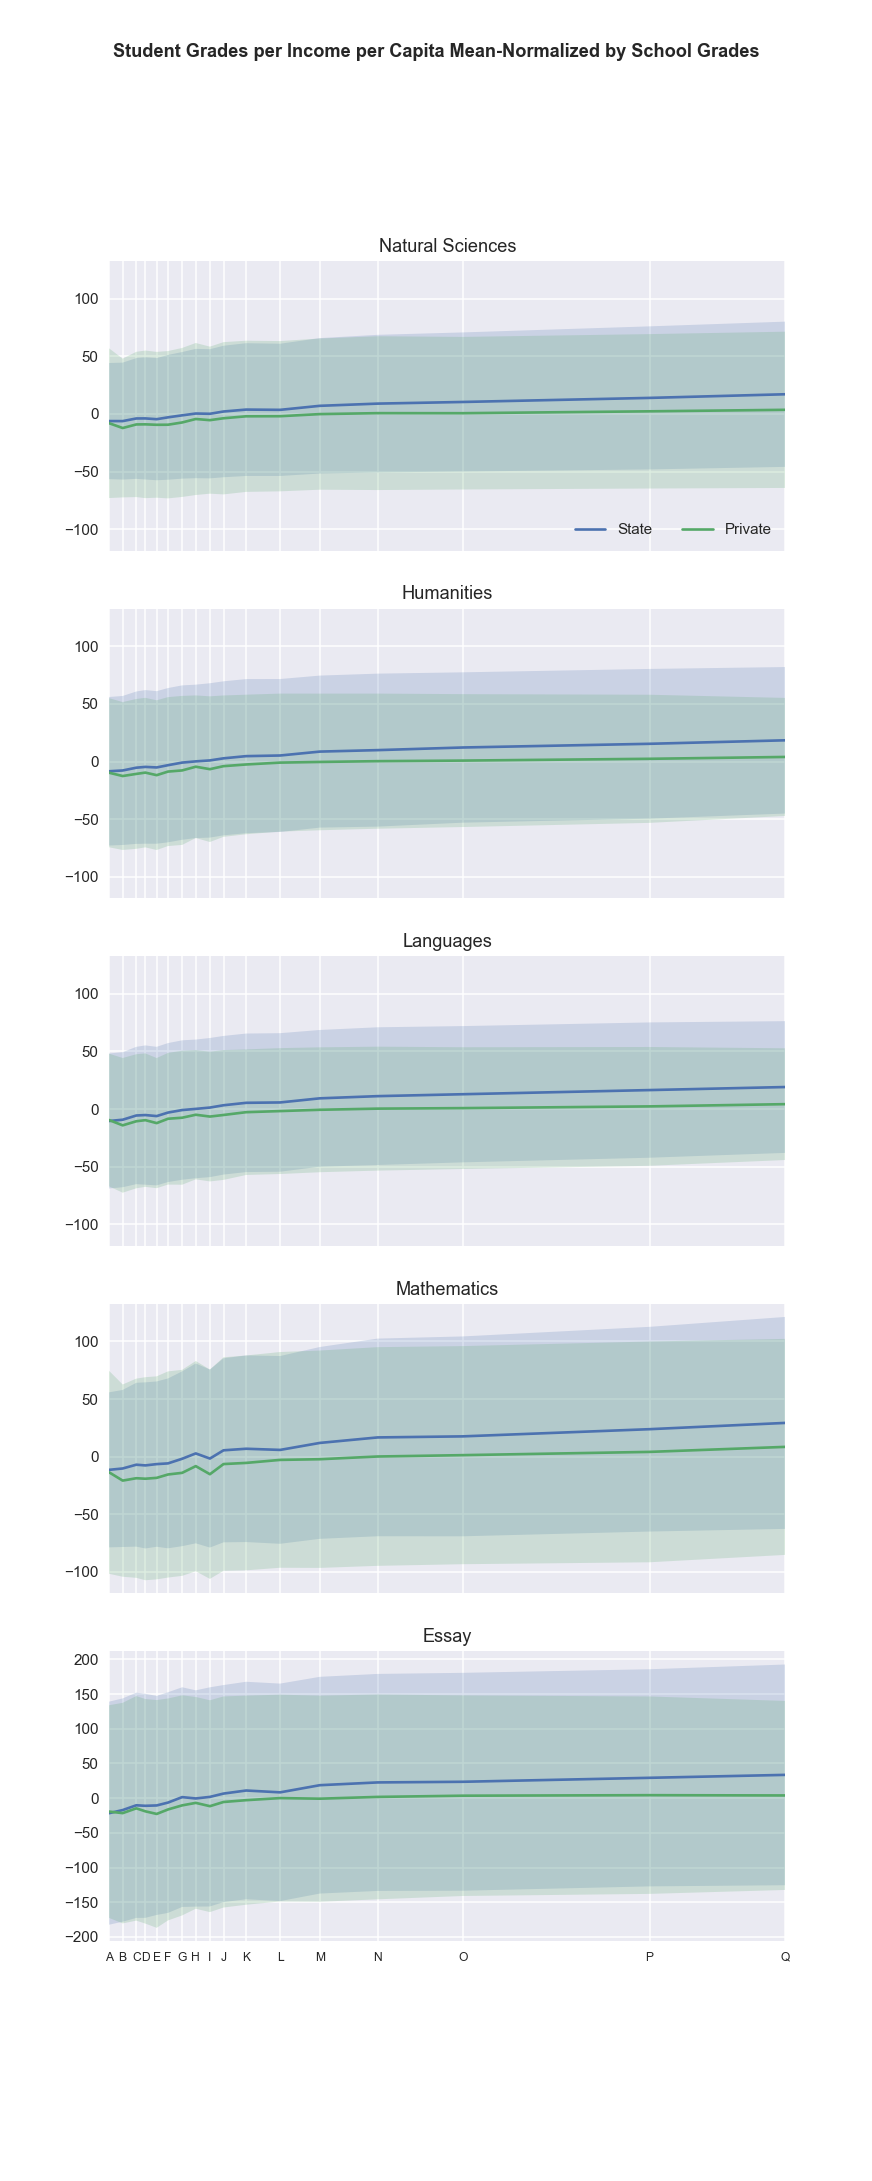

Federal  Municipal    Private     State
CH_NORM 11.925  -20.118072  -1.803263  -9.713623 -8.441890
        59.625  -17.146787  -8.002249 -12.580103 -7.760818
        107.325 -15.444295  -5.267351 -10.738786 -5.352293
        139.125 -11.402566  -8.138523  -9.613364 -4.655288
        178.875 -11.061800  -4.556621 -11.826492 -5.131472

In [23]:
normalized = df3
types = [
    'CN',
    'CH',
    'LC',
    'MT',
    'REDACAO'
]
for t in types:
    normalized['{}_NORM'.format(t)] = normalized['NU_NOTA_{}'.format(t)]-normalized['NU_NOTA_{}_SCHOOL'.format(t)]

    
binst = np.insert(income_per_person_bins, 0, 0)
bins = (binst[1:] + binst[:-1])/2
bins[-1] = binst[-2]

replace = {}
for i, c in enumerate(list('ABCDEFGHIJKLMNOPQ')):
    replace[c] = bins[i]

aux = normalized[[
        'TP_DEPENDENCIA_ADM_ESC',
        'INCOME_PER_PERSON_CATEGORY',
        'CN_NORM',
        'CH_NORM',
        'LC_NORM',
        'MT_NORM',
        'REDACAO_NORM',
    ]].groupby(by=[
        'TP_DEPENDENCIA_ADM_ESC',
        'INCOME_PER_PERSON_CATEGORY'
    ])

group_norm = (
    aux
    .agg('mean')
    .rename(index=replace, level=1)
    .rename(index={
        1.0: 'Federal',
        2.0: 'State',
        3.0: 'Municipal',
        4.0: 'Private'
    }, level=0)
    .reset_index()
    .pivot_table(
        index='TP_DEPENDENCIA_ADM_ESC',
        columns='INCOME_PER_PERSON_CATEGORY'
    ).T
)

group_std = (
    aux
    .agg('std')
    .rename(index=replace, level=1)
    .rename(index={
        1.0: 'Federal',
        2.0: 'State',
        3.0: 'Municipal',
        4.0: 'Private'
    }, level=0)
    .reset_index()
    .pivot_table(
        index='TP_DEPENDENCIA_ADM_ESC',
        columns='INCOME_PER_PERSON_CATEGORY'
    ).T
)


group_norm.index.names=[None, None]
del group_norm.columns.name

titles={
    'CH':'Humanities',
    'CN':'Natural Sciences',
    'LC':'Languages',
    'MT':'Mathematics',
    'REDACAO':'Essay'
}
fig = plt.figure(figsize = (8,20))

ax1 = plt.subplot(5,1,1)
for i, t in enumerate(types):
    ax = plt.subplot(5,1,i+1, sharex = ax1, sharey= ax1 if i<4 else None)
    group_norm.loc['{}_NORM'.format(t), ['State', 'Private']].plot(ax=ax, legend=i==0)
    ax.fill_between(
        group_norm.loc['{}_NORM'.format(t),'State'].index.values,
        (group_norm.loc['{}_NORM'.format(t),'State'] - group_std.loc['{}_NORM'.format(t),'State']).values,
        (group_norm.loc['{}_NORM'.format(t),'State'] + group_std.loc['{}_NORM'.format(t),'State']).values,
        alpha=0.2
    )
    ax.fill_between(
        group_norm.loc['{}_NORM'.format(t),'Private'].index.values,
        (group_norm.loc['{}_NORM'.format(t),'Private'] - group_std.loc['{}_NORM'.format(t),'Private']).values,
        (group_norm.loc['{}_NORM'.format(t),'Private'] + group_std.loc['{}_NORM'.format(t),'Private']).values,
        alpha=0.2
    )
    if(i==0):
        ax.legend(ncol=4, loc='lower right')
    ax.set_title(titles[t])
    plt.xticks(bins, labels='ABCDEFGHIJKLMNOPQ', fontsize=8)
fig.suptitle('Student Grades per Income per Capita Mean-Normalized by School Grades', fontweight='bold')

show_heads(group_norm)

In [24]:
print('P values from ANOVA')
for t in titles:
    _, p1 = stats.f_oneway(*[normalized.loc[
        (normalized['TP_DEPENDENCIA_ADM_ESC'] == 2.0) & 
        (normalized['INCOME_PER_PERSON_CATEGORY'] == c), 
        '{}_NORM'.format(t)
    ].values for c in 'ABCDEFGHIJKLMNOPQ'])

    _, p2 = stats.f_oneway(*[normalized.loc[
        (normalized['TP_DEPENDENCIA_ADM_ESC'] == 4.0) & 
        (normalized['INCOME_PER_PERSON_CATEGORY'] == c), 
        '{}_NORM'.format(t)
    ].values for c in 'ABCDEFGHIJKLMNOPQ'])
    print('  {}: \n    State:{} Private:{}'.format(titles[t], p1, p2))

P values from ANOVA
  Humanities: 
    State:0.0 Private:6.795257909018081e-232
  Natural Sciences: 
    State:0.0 Private:4.144792458030956e-145
  Languages: 
    State:0.0 Private:9.860230188159498e-298
  Mathematics: 
    State:0.0 Private:6e-323
  Essay: 
    State:0.0 Private:5.248714539247885e-84


plot student distibuition on schools

<IPython.core.display.Javascript object>


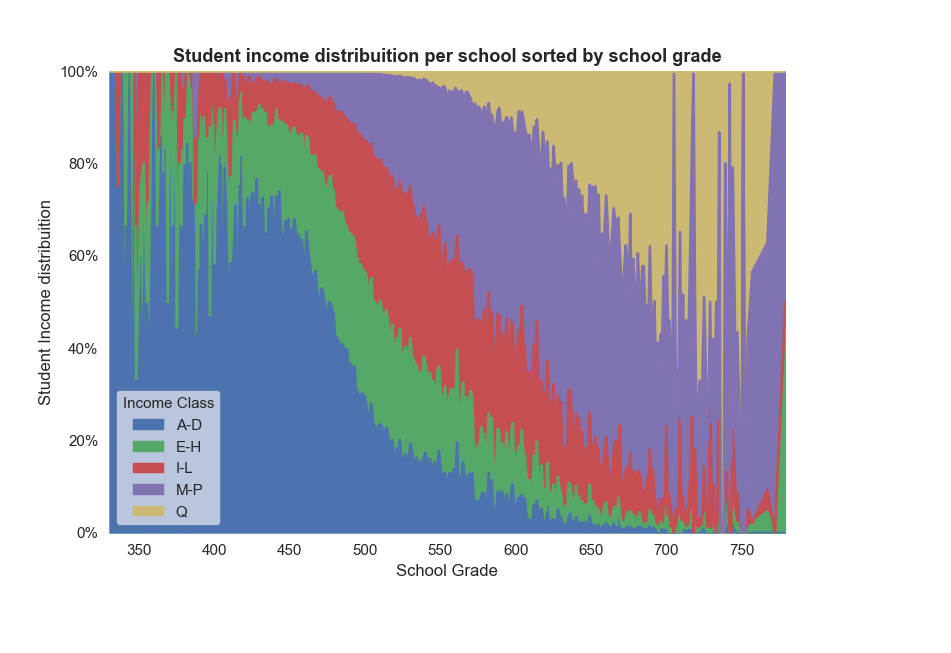

Class,A-D,E-H,I-L,M-P,Q
330,1.0,NaN,NaN,NaN,NaN
331,1.0,NaN,NaN,NaN,NaN
332,1.0,NaN,NaN,NaN,NaN
333,NaN,1.0,NaN,NaN,NaN
334,1.0,NaN,NaN,NaN,NaN


In [25]:
dist = pd.DataFrame(df3[[
    'CO_ESCOLA',
    'INCOME_PER_PERSON_CATEGORY'
]])
dist['NOTA'] = df3[[
    'NU_NOTA_CN_SCHOOL',
    'NU_NOTA_CH_SCHOOL',
    'NU_NOTA_LC_SCHOOL',
    'NU_NOTA_MT_SCHOOL',
    'NU_NOTA_REDACAO_SCHOOL'
]].mean(axis=1)
renameMap = {
    'A':'A-D',
    'B':'A-D',
    'C':'A-D',
    'D':'A-D',
    'E':'E-H',
    'F':'E-H',
    'G':'E-H',
    'H':'E-H',
    'I':'I-L',
    'J':'I-L',
    'K':'I-L',
    'L':'I-L',
    'M':'M-P',
    'N':'M-P',
    'O':'M-P',
    'P':'M-P',
    #'Q':'Q'
}

dist = dist.astype({'NOTA':np.int}).replace({
    'INCOME_PER_PERSON_CATEGORY':renameMap
})
dist = (dist
    .pivot_table(
        index='NOTA',
        columns='INCOME_PER_PERSON_CATEGORY',
        aggfunc='count'
    )['CO_ESCOLA']
)

dist = dist.div(dist.sum(axis=1),axis=0)

dist.index.names=[None]
dist.columns.names=['Class']

dist.plot.area()
plt.ylim(top=1, bottom=0)
plt.xlabel('School Grade')
plt.ylabel('Student Income distribuition')
plt.legend(title="Income Class", fancybox=True,framealpha = .7, frameon=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
_ = plt.title('Student income distribuition per school sorted by school grade', fontweight='bold')
show_heads(dist)

# Conclusions

Is per person family income an important factor in student performace on the enem test? 
The 'Student Grades and Distribuition Across School Types per Income per Capita' graph shows the ideia that income indeed plays a role in student performance. Although the values of performance in different income categories remain inside the standard deviation, we can observe an notable tendency that more income will result on a higher grade, both on public(state) and private schools. This is confirmed by ANOVA results, which states that it is highly unlikely that all classes will have the same grades. The reason behind this effect is that more income comes with more options in choosing the best school to attend, being it a private or a public school. 

The investigation on the grades normalized by school mean pointed to a more subtle result. We see a slight slope on every discipline evaluated by the enem test, especially mathematics and essays, but this slope is not very big when compared to the standard deviation. The ANOVA test indicates that there highly likely to exist a diference in performace due to income classes on this normalized observation. 

These observations indicate that, on both private and state schools, income plays a small role in student performace given the school he/she studies, but the distribuition of students across the schools play a major role in their final performance on the test, with the students with low per person family income being assigned, in general, to the worst schools (as we can see in graph 'Student income distribuition per school sorted by school grade').
